# Variational AutoEncoder(VAE)
- Representation Learning(표현학습)
  - 개념 벡터(Concept Vector): 잠재공간(Latent Space)이나 임베딩(Embedding)이 주어지면 이 공간의 어떤 방향은 원본데이터의 변화를 인코딩한 축일 수 있음
  - 개념 벡터의 연산으로 변형된 이미지를 복원(Decoding)하여 생성 가능
- Example
  - 원통의 '높이'와 '너비'
    - 높이가 낮고 너비가 넓은 원통 이미지 생성
  - 눈의 '크기' 및 '색', 머리카락의 '길이' 및 '색'
    - 긴 검은머리에 갈색의 큰 눈을 가진 이미지 생성
- Decoder(Generator) 학습을 위해 Encoder 사용

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!nvidia-smi

Mon Mar 29 07:49:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
from scipy.stats import norm

In [24]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras import backend as K
from keras.models import Model
from keras import objectives

## 1. MNIST Data Load

In [5]:
(X_train, y_train) , (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


- Normalization and Reshape

In [6]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

## 2. Keras Modeling with Functional API

### 1) 'Latent Space' Point Mapping
- 각 이미지가 '잠재공간(Latent Space) 포인트' 주변의 '다변수 정규분포(Multivariate Normal Distribution)'에 매핑

In [8]:
input_img = Input(shape = (784,))

encoded = Dense(256, activation = 'elu')(input_img)
encoded = Dense(128, activation = 'elu')(encoded)

- Variational(Latent Space) Layers
  - 평균(mean)과 분산(log_var)으로 인코딩된 잠재공간(Latent Space) 포인트 분포

In [9]:
mean = Dense(2, name = 'mean')(encoded)
log_var = Dense(2, name = 'var')(encoded) # 분산에 log를 씌워 처리

# encoded에 누적하지 않음
# encoded에 평균과 분산을 연결시켜줌
# 평균 2개, 분산 2개

### 2) 'Latent Space' Sampling
- 잠재공간(Latent Space)의 잠재공간-포인트(z) 샘플링
  - 정규분포에서 무작위로 선택한 'epsilon'값 사용
    - Encoding 결과값을 그대로 사용하면 항상 같은 결과만 생성
    - 따라서 랜덤 샘플링을 통하여 기존 Data에 존재하지 않는 새로운 Image 생성
- Lambda(): 임의의 파이썬 함수 객체를 Keras Layer로 생성
- K.exp(log_var): 로그분산 -> 표준편차 변환

- 학습된 평균과 분산이 아닌 새로운 샘플을 만들어내고
- 샘플을 뽑아낼 때마다 학습된 분포에서 새로운 형태가 나오게 된다


In [11]:
def sampling(args) :
  mean, log_var = args
  epsilon = K.random_normal(shape = (100, 2),
                            mean = 0.,
                            stddev = 1.0)
  
  return mean + K.exp(log_var) * epsilon 


  # 입실론(eps)을 곱해줌(랜덤값을 입실론으로 조절해줌)
  # 입실론: 정규분포에서 랜덤한 값 하나를 뽑아옴 (z 분포)
  # 실제 평균값에서 분산을 이동한 형태가 됨  

In [12]:
z = Lambda(sampling, output_shape = (2,))([mean, log_var])

# 값들은 벡터로 연산한 것이지, DNN의 레이어들이 아니다
# 레이어 형태로 동작되게 하기 위해 keras lambda 함수 사용
# (임의의 파이썬 함수 객체를 keras layer로 생성)
# output shape이 (2,)인 layer로 나타나게 된다

### 3) 'encoder' Model

In [14]:
encoder = Model(input_img, mean)
# 평균 레이어만 넣어 학습 (분산을 넣으면 학습이 제대로 되지 않는다)

In [15]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
mean (Dense)                 (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


### 4) 'generator' Model
- 만드는 방법 다양
- encoder와 대칭모양으로 만들지 않아도 된다

- Decoding Layer Structure

In [16]:
decoder_1 = Dense(128, activation = 'elu')
decoder_2 = Dense(256, activation = 'elu')
decoder_3 = Dense(784, activation = 'sigmoid')

- 랜덤 샘플링 '잠재공간-포인트(Z)' 재구성

In [17]:
z_sample = decoder_1(z)          # z를 넣어 z_sample 생성
z_sample = decoder_2(z_sample)
z_sample = decoder_3(z_sample)

In [18]:
z_sample.shape # 랜덤값을 100개씩 뽑게 만들었으므로(배치), (100, 784)

TensorShape([100, 784])

- Generator Layers

In [19]:
decoder_input = Input(shape = (2,))

y_gen = decoder_1(decoder_input)
y_gen = decoder_2(y_gen)
y_gen = decoder_3(y_gen)

- Build 'generator'

In [20]:
generator = Model(decoder_input, y_gen)

- 'generator' Model Summary

In [21]:
generator.summary()
# z가 연산되는 과정 때문에 multiple로 나타남

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              multiple                  384       
_________________________________________________________________
dense_3 (Dense)              multiple                  33024     
_________________________________________________________________
dense_4 (Dense)              multiple                  201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


## 3. VAE Fit

### 1) 'vae' Model Define
- Build 'vae' Model
  - End-to-End AutoEncoder

In [22]:
vae = Model(input_img, z_sample) # input_image, z_sample을 넣어서 VAE구현

- 'vae' Model Summary

In [23]:
vae.summary() # lambda 안에 평균, 분산 들어가있음을 확인할 수 있다

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            258         dense_1[0][0]                    
____________________________________________________________________________________________

### 2) Model Compile
- Define 'vae_loss'
  - reconstruction_loss: 입력값 재구성 손실
    - 원본 이미지와 생성된 이미지 사이의 오차(CEE)
    - '샘플링 함수'로 생성한 'z'값으로 얼마나 원본이미지와 유사한 이미지를 잘 생성하는가?
  - kl_loss: 사전 분포와 잠재 분포 사이의 Kullback Leibler-Divergence(두 확률분포 간 거리)
    - 사전분포(Prior Distribution): 원본이미지 확률분포
    - 잠재분포(Latent Distribution): 잠재공간 확률분포
    - '샘플링 함수'의 값이 원본 이미지의 확률분포와 유사한가?

In [26]:
# 학습의 목표 자체가 다르다
# encoder와 decoder의 목적이 다르므로 loss가 두개. 두개를 최소화해야 한다

# 평균, 분산을 통해 만들어진 z 
# 두 확률분포의 유사도를 측정하는 방법: kl_loss 
# 두 분포가 다를 때 분포 사이의 거리(오차)
# 오차를 줄여가는 것이 좋음

reconstruction_loss = objectives.binary_crossentropy(input_img, z_sample)
kl_loss = 0.0005 * K.mean(K.square(mean) + K.exp(log_var) - log_var - 1, axis = -1)
# 오차의 적용 비율을 정해줄 수 있음 (하이퍼파라미터)
# 비율에 따라 학습이 잘 되기도, 안되기도 함

vae_loss = reconstruction_loss + kl_loss # vae_loss 는 두 오차를 더해 구함

# 사실 모델이 2개 있는 것
# 두 모델에 다른 형태로 파라미터가 학습되도록 loss함수가 두개 있는 것

- Add vae_loss

In [27]:
vae.add_loss(vae_loss)

- Compile with vae_loss

In [28]:
vae.compile(optimizer = 'adam')

### 3) Model Training 
- 약 8분

In [29]:
%%time

vae.fit(X_train,
        shuffle = True,
        epochs = 300,
        batch_size = 100,
        validation_data = (X_test, None)) # 학습하면서 생성된 이미지가 실제 이미지와 비슷한지 비교

# 자기가 들어가서, 자기와 같은 형태의 무언가가 나오는지 보는 것
# 지도학습이 아님! (자기와 분포가 비슷한 새로운 것을 생성)

# 학습하면서 생성된 이미지가 실제 이미지와 비슷한지 비교
# encoder에서 나온 평균, 분산 값이 잘 표현하도록 학습

# 튜닝하기가 쉽지 않다

Epoch 1/300
600/600 [==============================] - 4s 3ms/step - loss: 0.2738 - val_loss: 0.2168
Epoch 2/300
600/600 [==============================] - 1s 2ms/step - loss: 0.2160 - val_loss: 0.2093
Epoch 3/300
600/600 [==============================] - 1s 2ms/step - loss: 0.2069 - val_loss: 0.2014
Epoch 4/300
600/600 [==============================] - 1s 2ms/step - loss: 0.2000 - val_loss: 0.1967
Epoch 5/300
600/600 [==============================] - 1s 2ms/step - loss: 0.1948 - val_loss: 0.1927
Epoch 6/300
600/600 [==============================] - 1s 2ms/step - loss: 0.1913 - val_loss: 0.1902
Epoch 7/300
600/600 [==============================] - 1s 2ms/step - loss: 0.1884 - val_loss: 0.1879
Epoch 8/300
600/600 [==============================] - 1s 2ms/step - loss: 0.1865 - val_loss: 0.1860
Epoch 9/300
600/600 [==============================] - 1s 2ms/step - loss: 0.1850 - val_loss: 0.1843
Epoch 10/300
600/600 [==============================] - 1s 2ms/step - loss: 0.1838 - val_lo

## 4. 'Latent Space' Visualization

### 1) Classes in the Latent Space

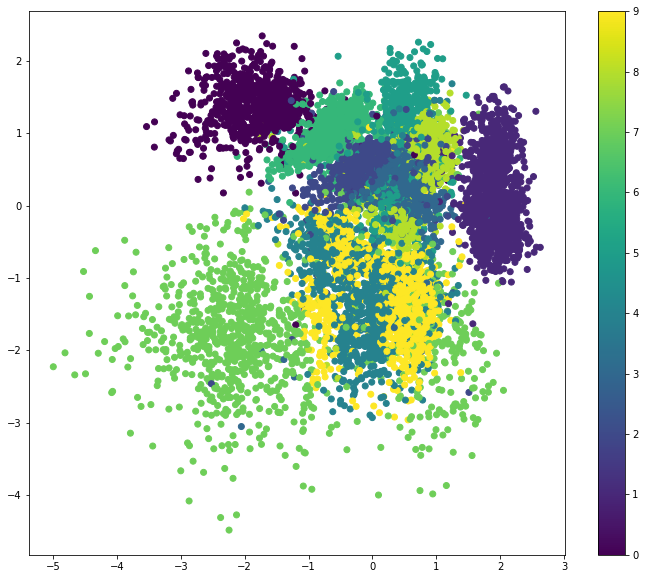

In [31]:
X_test_latent = encoder.predict(X_test, batch_size = 100)
# 100개씩 뽑아내고, batch_size 100으로 predict

plt.figure(figsize = (12, 10))
plt.scatter(X_test_latent[: , 0],
            X_test_latent[: , 1],
            c = y_test)
plt.colorbar()
plt.show()

### 2) Display 2D Manifold(20 * 20)
- 두 개의 '개념벡터(Concept Vector)'로 데이터의 특징을 '표현(Representation)'
  - 두께, 회전각도 등

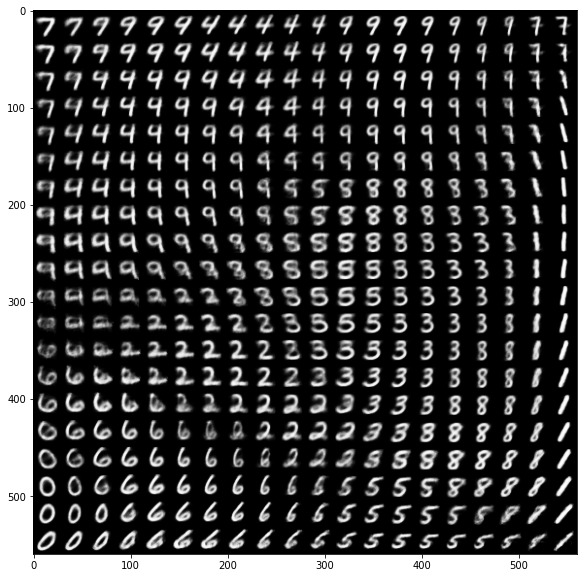

In [33]:
n = 20
digit_size = 28
figure = np.zeros((digit_size * n , digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    x_decoded = generator.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size : (i + 1) * digit_size,
           j * digit_size : (j + 1) * digit_size] = digit

plt.figure(figsize = (10, 10))
plt.imshow(figure, cmap = 'Greys_r')
plt.show()

# 좌표가 움직이면서 특징이 조금씩 바뀌어가는 것을 볼 수 있다

## 5. 'generator' Test(784 -> 2)

### 1) 'encoder' Test (784 -> 2)

In [34]:
encoded_latent = encoder.predict(X_test)

encoded_latent.shape

(10000, 2)

### 2) 'generator' Test (2 -> 784)

In [36]:
generated_imgs = generator.predict(encoded_latent)

generated_imgs.shape
# 2개의 표현을 가지고 생성된 이미지 확인

(10000, 784)

### 3) Generating Visualization
- 복원이 아닌 생성된 이미지들

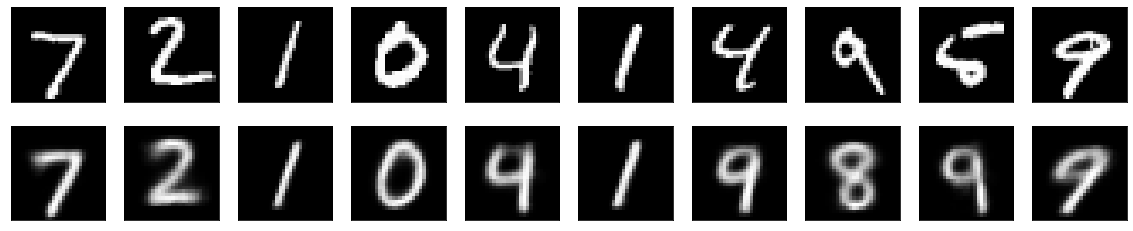

In [37]:
n = 10

plt.figure(figsize = (20, 4))
for i in range(n) :

  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(generated_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()